## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [ ]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#import eli5
#from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [ ]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
#train_path = '/data/ephemeral/home/train.csv'
#test_path  = '/data/ephemeral/home/test.csv'
pre_path = '/data/ephemeral/home/merge9.csv'
#dt = pd.read_csv(train_path)
#dt_test = pd.read_csv(test_path)
dt = pd.read_csv(pre_path)

In [ ]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape)

Train data shape :  (1128094, 40)


In [ ]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [ ]:
display(dt_pre.head(1))

,Unnamed: 0,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1


In [ ]:
dt_pre.isnull().sum()

Unnamed: 0                       0
시군구                              0
번지                               0
본번                              75
부번                              75
아파트명                          1555
전용면적                             0
계약년월                             0
계약일                              0
층                                0
건축년도                             0
도로명                              0
해제사유발생일                    1121899
등기신청일자                     1111271
거래유형                       1086451
중개사소재지                     1090013
k-단지분류(아파트,주상복합등등)          258873
k-전화번호                      876850
k-팩스번호                      879348
단지소개기존clob                  910113
k-세대타입(분양형태)                257015
k-관리방식                      257015
k-복도유형                      258071
k-난방방식                      256733
k-전체동수                      258591
k-전체세대수                     256422
k-건설사(시공사)                  260287
k-시행사                       260767
k-사용검사일-사용승인일       

In [ ]:
dt_density = dt_pre[['시군구','번지','계약년월', '계약일', 'target', 'is_test']]
dt_density

,시군구,번지,계약년월,계약일,target,is_test
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0
...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1


In [ ]:
dt_density.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   번지       1128094 non-null  object 
 2   계약년월     1128094 non-null  int64  
 3   계약일      1128094 non-null  int64  
 4   target   1118822 non-null  float64
 5   is_test  1128094 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 51.6+ MB


In [ ]:
dt_density['동'] = dt_density['시군구'].str.split().str[1]
dt_density

,시군구,번지,계약년월,계약일,target,is_test,구
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0,강남구
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0,강남구
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0,강남구
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0,강남구
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0,강남구
...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1,중랑구
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1,중랑구
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1,중랑구
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1,중랑구


In [ ]:
dt.isnull().sum()

index                 0
아파트명               2136
전용면적                  0
계약년월                  0
계약일                   0
층                     0
건축년도                  0
도로명                   0
target             9272
is_test               0
지번주소                  0
좌표X                   0
좌표Y                   0
k-복도유형           257306
k-단지분류           258835
주차대수                  0
구                     0
동                     0
계약년                   0
계약월                   0
계약년월일                 0
도로                 1393
강남여부                  0
부촌여부                  0
상위아파트여부               0
top아파트거리              0
브랜드명                  0
건물연식                  0
대장아파트거리               0
인근지하철역개수              0
도로명_실거래가순위            0
도로_실거래가순위             0
동_실거래가순위              0
재건축                   0
기준금리                  0
CLI                   0
자치구별 지하철 승객 수         0
공시지가                  0
아파트전세가격지수             0
학군                    0
dtype: int64

In [ ]:
dt[dt['계약년월'] < 201304]

,index,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,target,is_test,...,도로명_실거래가순위,도로_실거래가순위,동_실거래가순위,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
95369,95369,개포6차우성,67.28,201112,17,1,1987,언주로 3,68000.0,0,...,927,35,48,0.0,1.25,91.9,103623363.0,4.060541e+06,91.8,0
95370,95370,개포우성3차,104.43,201204,13,6,1984,개포로 307,85000.0,0,...,432,77,48,0.0,1.25,91.9,103623363.0,4.060541e+06,91.8,0
95371,95371,개포자이,134.30,201205,8,14,2004,개포로109길 69,119500.0,0,...,314,77,48,0.0,1.25,91.9,103623363.0,4.060541e+06,91.8,0
95372,95372,개포주공1단지,35.64,201110,5,1,1982,개포로,57000.0,0,...,1421,77,48,0.0,1.25,91.9,103623363.0,4.060541e+06,91.8,0
95373,95373,개포주공1단지,58.08,201110,5,4,1982,개포로,91750.0,0,...,1421,77,48,0.0,1.25,92.3,103623363.0,4.060541e+06,92.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,1118817,갈현현대,59.94,200707,12,11,1998,서오릉로21길 36,20000.0,0,...,7023,493,281,0.0,4.50,63.2,73185743.0,2.421824e+06,53.4,1
1118818,1118818,갈현현대,59.94,200708,25,10,1998,서오릉로21길 36,20000.0,0,...,7023,493,281,0.0,4.50,63.0,73185743.0,2.421824e+06,53.4,1
1118819,1118819,갈현현대,84.83,200708,31,20,1998,서오릉로21길 36,28000.0,0,...,7023,493,281,0.0,5.00,64.3,73185743.0,2.421824e+06,53.5,1
1118820,1118820,갈현현대,84.83,200709,15,8,1998,서오릉로21길 36,29000.0,0,...,7023,493,281,0.0,4.50,62.3,73185743.0,2.421824e+06,52.5,1


In [ ]:
price = pd.read_csv('/data/ephemeral/home/전세평균가격_0723.csv',encoding='cp949')
price

,지역명,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,종로구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,753.981963,756.240260,758.350279,763.265394,766.859523,772.821629,781.122306,787.201041,790.146881,794.950462
1,중구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,737.668336,735.430095,734.003462,734.927676,736.895486,738.877199,742.819479,747.496832,750.497685,758.048759
2,용산구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,812.175121,802.058153,798.348383,802.946954,809.655836,833.823274,837.663102,840.472634,842.465830,847.491840
3,성동구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,813.760281,812.959580,817.037372,821.442538,825.052048,828.889583,831.608310,835.147525,837.241882,841.853874
4,광진구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,749.599964,747.878849,750.613655,756.823190,764.396383,768.048625,771.517984,775.284746,777.298550,778.805571
5,동대문구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,601.911385,601.252399,601.272412,602.185772,604.818987,606.312860,609.478547,617.248030,618.229380,621.159380
6,중랑구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,531.687724,526.514101,524.717203,524.799293,526.450716,527.181544,528.080330,529.518040,529.008259,530.025387
7,성북구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,588.326929,584.879351,582.845633,585.263760,588.796228,601.338143,604.988639,610.249814,611.409879,614.312949
8,강북구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,489.644461,487.043445,486.420884,488.864928,490.943572,492.662343,495.786126,501.091342,502.002160,504.089090
9,도봉구,196.380125,197.637995,199.089885,201.326413,201.616936,201.835096,202.314603,203.039425,203.797136,...,446.858554,437.701594,430.601344,428.665675,430.614922,432.424276,432.197621,433.149650,433.945665,437.472773


In [ ]:
melted_df = price.melt(id_vars='지역명', var_name='계약년월', value_name='전세평균가격')
melted_df = melted_df.rename(columns={'지역명':'구'})
melted_df

,구,계약년월,전세평균가격
0,종로구,2007-01,196.380125
1,중구,2007-01,196.380125
2,용산구,2007-01,196.380125
3,성동구,2007-01,196.380125
4,광진구,2007-01,196.380125
...,...,...,...
5170,관악구,2024-03,576.012841
5171,서초구,2024-03,1085.134436
5172,강남구,2024-03,1074.279150
5173,송파구,2024-03,909.315914


In [ ]:
# 날짜 형식 변경 함수 정의
def convert_date(date_str):
    return date_str.replace('-', '')

# 날짜 형식 변경 적용
melted_df['계약년월'] = melted_df['계약년월'].apply(convert_date)
melted_df

,구,계약년월,전세평균가격
0,종로구,200701,196.380125
1,중구,200701,196.380125
2,용산구,200701,196.380125
3,성동구,200701,196.380125
4,광진구,200701,196.380125
...,...,...,...
5170,관악구,202403,576.012841
5171,서초구,202403,1085.134436
5172,강남구,202403,1074.279150
5173,송파구,202403,909.315914


In [ ]:
melted_df.to_csv('price_0723.csv', index=False)

In [ ]:
dt_density['year'] = dt_density['계약년월']/100
dt_density['year'] = dt_density['year'].astype(int)
dt_density

,시군구,번지,계약년월,계약일,target,is_test,구,year
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0,강남구,2017
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0,강남구,2017
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0,강남구,2017
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0,강남구,2018
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0,강남구,2018
...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1,중랑구,2023
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1,중랑구,2023
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1,중랑구,2023
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1,중랑구,2023


In [ ]:
df_merged = pd.merge(dt_density, melted_df, on=['구', 'year'], how='left')
df_merged

,시군구,번지,계약년월,계약일,target,is_test,구,year,인구밀도
0,서울특별시 강남구 개포동,658-1,201712,8,124000.0,0,강남구,2017,14203
1,서울특별시 강남구 개포동,658-1,201712,22,123500.0,0,강남구,2017,14203
2,서울특별시 강남구 개포동,658-1,201712,28,91500.0,0,강남구,2017,14203
3,서울특별시 강남구 개포동,658-1,201801,3,130000.0,0,강남구,2018,13859
4,서울특별시 강남구 개포동,658-1,201801,8,117000.0,0,강남구,2018,13859
...,...,...,...,...,...,...,...,...,...
1128089,서울특별시 중랑구 신내동,479,202307,28,NaN,1,중랑구,2023,20948
1128090,서울특별시 중랑구 신내동,479,202308,10,NaN,1,중랑구,2023,20948
1128091,서울특별시 중랑구 신내동,479,202309,2,NaN,1,중랑구,2023,20948
1128092,서울특별시 중랑구 중화동,208-4,202307,14,NaN,1,중랑구,2023,20948


In [ ]:
df_merged.to_csv('population_density.csv', index=False)

In [ ]:
# 'date'와 'is_test'가 0인 데이터만 선택
filtered_data = df_merged[df_merged['is_test'] == 0]

filtered_data = filtered_data[df_merged['구'] == '강남구']

grouped_data = filtered_data.groupby('계약년월')

grouped_data = grouped_data.mean().reset_index()

grouped_data.reset_index(drop=True, inplace=True)

grouped_data.drop(columns=['계약일', 'is_test'], inplace=True)

grouped_data['계약년월'] = grouped_data['계약년월'].astype(str)

grouped_data

,계약년월,target,year,인구밀도
0,200701,60014.643979,2007.0,14396.0
1,200702,61114.664557,2007.0,14396.0
2,200703,56418.932692,2007.0,14396.0
3,200704,67416.182390,2007.0,14396.0
4,200705,71905.342593,2007.0,14396.0
...,...,...,...,...
193,202302,176959.381443,2023.0,13932.0
194,202303,207304.232804,2023.0,13932.0
195,202304,224626.050000,2023.0,13932.0
196,202305,212485.223881,2023.0,13932.0


In [ ]:
# 'date'와 'is_test'가 0인 데이터만 선택
filtered_data = df_merged[df_merged['is_test'] == 0]

# 'date'를 기준으로 그룹화하고 각 그룹에 대해 '기준금리'와 'target'의 평균 계산
grouped_data = filtered_data.groupby('계약년월')

grouped_data = grouped_data.mean().reset_index()

grouped_data.reset_index(drop=True, inplace=True)

grouped_data.drop(columns=['계약일', 'is_test'], inplace=True)

grouped_data['계약년월'] = grouped_data['계약년월'].astype(str)

grouped_data

,계약년월,target,year,인구밀도
0,200701,27907.070115,2007.0,18805.654253
1,200702,28687.696452,2007.0,18801.992531
2,200703,26188.014682,2007.0,19075.582859
3,200704,29135.020486,2007.0,18869.452499
4,200705,32721.145273,2007.0,18672.006099
...,...,...,...,...
193,202302,98699.860181,2023.0,17318.653013
194,202303,101508.679474,2023.0,17188.020768
195,202304,105340.274426,2023.0,17385.467688
196,202305,108825.542857,2023.0,17181.185429


In [ ]:
# '기준금리'와 'target'에 이동평균 적용
grouped_data['target_이동평균'] = grouped_data['target'].rolling(window=5, min_periods=1).mean()

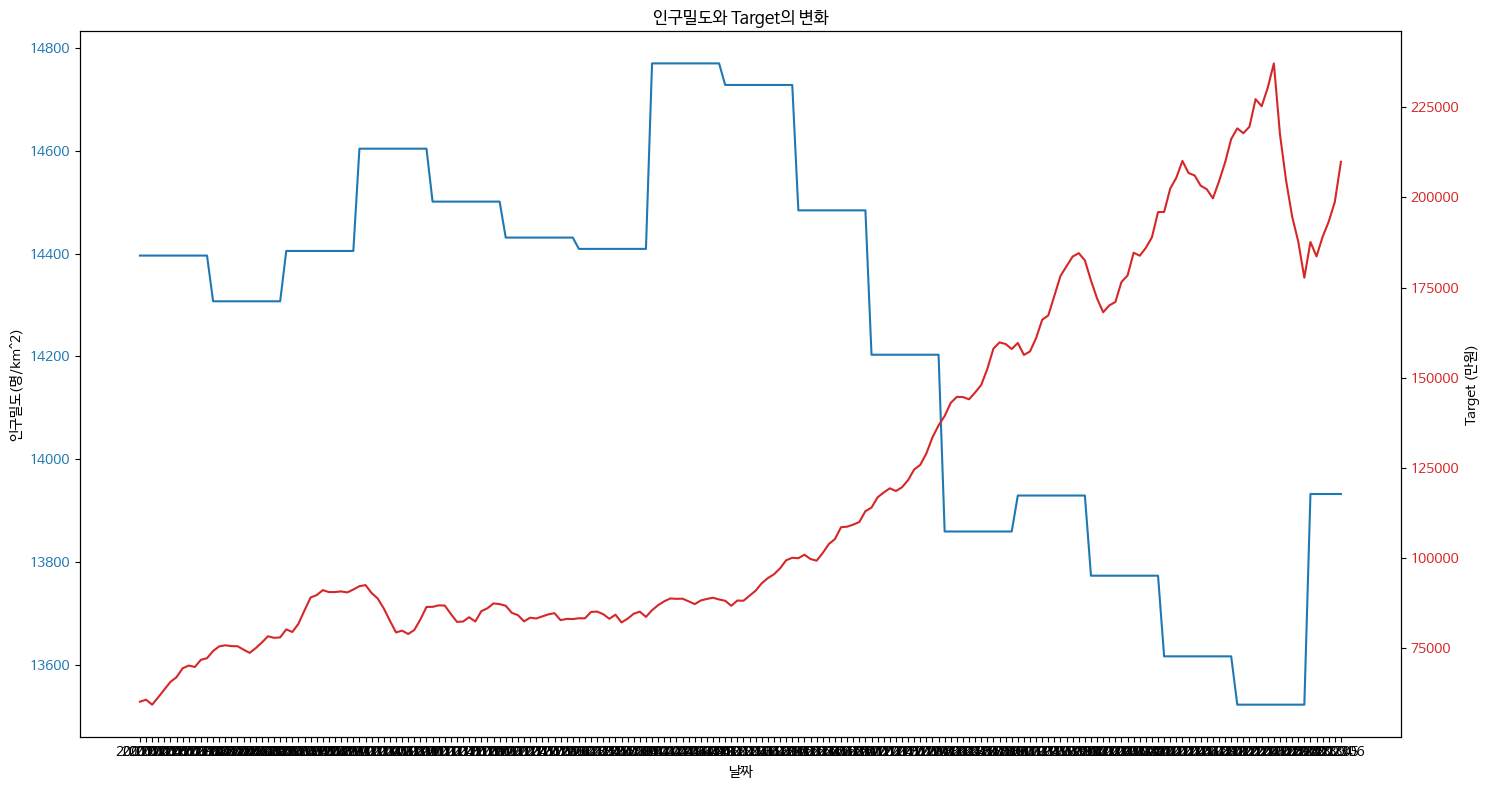

In [ ]:
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(15, 8))

# 기준금리를 첫 번째 축에 표시
ax1.plot(grouped_data['계약년월'], grouped_data['인구밀도'], color='tab:blue', label='인구밀도')
ax1.set_xlabel('날짜')
ax1.set_ylabel('인구밀도(명/km^2)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# target을 두 번째 축에 표시
ax2 = ax1.twinx()
ax2.plot(grouped_data['계약년월'], grouped_data['target_이동평균'], color='tab:red', label='target')
ax2.set_ylabel('Target (만원)')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('인구밀도와 Target의 변화')
plt.xticks(rotation=0)
fig.tight_layout()
plt.show()